Below is loading in data and shaping them to be able to work for backpropagation

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
X_train = np.loadtxt('X_train.csv', delimiter=' ')
Y_train = np.loadtxt('Y_train.csv', delimiter=' ')
X_test = np.loadtxt('X_test.csv', delimiter=' ')
Y_test = np.loadtxt('Y_test.csv', delimiter=' ')

# Transpose X arrays and reshape Y arrays to correct shapes
X_train = X_train.T
Y_train = Y_train.reshape((1, -1))
X_test = X_test.T
Y_test = Y_test.reshape((1, -1))



Below is all functions used in the program

In [90]:
# Initialize parameters
def init_params(input_dim, hidden_dim, output_dim):
    np.random.seed(3)
    params = {
        'W1': np.random.randn(hidden_dim, input_dim) * 0.01,
        'b1': np.zeros((hidden_dim, 1)),
        'W2': np.random.randn(output_dim, hidden_dim) * 0.01,
        'b2': np.zeros((output_dim, 1)),
    }
    return params

# Activation functions and their derivatives
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z)), Z

def sigmoid_derivative(dA, Z):
    sig = 1 / (1 + np.exp(-Z))
    return dA * sig * (1 - sig)

# For regression, let's use a linear activation for the output layer
def linear_activation(Z):
    return Z, Z

def mean_squared_error(Y_hat, Y):
    return np.mean(np.power(Y_hat - Y, 2))

def tanh(Z):
    return np.tanh(Z), Z

def tanh_derivative(dA, Z):
    return dA * (1 - np.tanh(Z)**2)

def relu(Z):
    return np.maximum(0, Z), Z

def relu_derivative(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ


def forward_propagation(X, params, activation_fn):
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']

    Z1 = np.dot(W1, X) + b1
    A1, _ = activation_fn(Z1)  # Use specified activation function

    Z2 = np.dot(W2, A1) + b2
    A2, _ = linear_activation(Z2)

    cache = ((Z1, A1, W1, b1), (Z2, A2, W2, b2))
    return A2, cache

def backpropagation(X, Y, cache, params, activation_derivative_fn):
    m = X.shape[1]
    (Z1, A1, W1, b1), (Z2, A2, W2, b2) = cache

    # Output layer gradients remain the same, as we're using linear activation for the output
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # Hidden layer gradients use the passed derivative function
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = activation_derivative_fn(dA1, Z1)  # Use the specified activation function's derivative
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    return grads

def update_parameters(params, grads, learning_rate):
    params['W1'] -= learning_rate * grads['dW1']
    params['b1'] -= learning_rate * grads['db1']
    params['W2'] -= learning_rate * grads['dW2']
    params['b2'] -= learning_rate * grads['db2']
    return params


def test(X, Y, params):
    Y_hat, _ = forward_propagation(X, params, sigmoid)
    loss = mean_squared_error(Y_hat, Y)
    return Y_hat, loss

# Add a new function to calculate the R2 score manually (since we can't import sklearn)
def r2_score_manual(Y_true, Y_pred):
    ss_res = np.sum((Y_true - Y_pred) ** 2)
    ss_tot = np.sum((Y_true - np.mean(Y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def train(X, Y, hidden_dim, learning_rate, epochs, activation_fn, activation_derivative_fn):
    params = init_params(X.shape[0], hidden_dim, Y.shape[0])
    loss_history, r2_history = [], []

    for i in range(epochs):
        Y_hat, cache = forward_propagation(X, params, activation_fn)
        loss = mean_squared_error(Y_hat, Y)
        loss_history.append(loss)
        r2_history.append(r2_score_manual(Y, Y_hat))

        grads = backpropagation(X, Y, cache, params, activation_derivative_fn)
        params = update_parameters(params, grads, learning_rate)

        #if i % 100 == 0: print(f"Epoch {i}, Loss: {loss}")

    return params, loss_history, r2_history

def evaluate_hidden_layer_neurons(X_train, Y_train, X_test, Y_test, neuron_range, learning_rate, epochs):
    mse_losses = []
    predictions = []

    for neurons in neuron_range:
        # Train the model with the current number of neurons in the hidden layer
        trained_params, _, _ = train(X_train, Y_train, neurons, learning_rate, epochs, sigmoid, sigmoid_derivative)

        # Evaluate the model on the test set with the new parameters
        Y_hat_test, test_mse = test(X_test, Y_test, trained_params)
        mse_losses.append(test_mse)

        # Store the predictions for plotting later
        predictions.append(Y_hat_test)

    # Plotting the MSE losses
    plt.figure(figsize=(10, 5))
    plt.plot(neuron_range, mse_losses, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Neurons in Hidden Layer')
    plt.ylabel('Test MSE Loss')
    plt.title('Test MSE Loss as a Function of Number of Hidden Layer Neurons')
    plt.grid(True)
    plt.show()

    # Plot the predicted vs actual values for each neuron configuration
    fig, axes = plt.subplots(nrows=len(neuron_range), ncols=1, figsize=(10, 20))
    fig.tight_layout(pad=5.0)

    for i, ax in enumerate(axes):
        ax.plot(Y_test.flatten(), label='True values', linewidth=2)
        ax.plot(predictions[i].flatten(), label='Predicted values', linestyle='--', linewidth=2)
        ax.set_title(f'{neuron_range[i]} Neurons in Hidden Layer')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)

    plt.show()

    return

def evaluate_learning_rates(X_train, Y_train, X_test, Y_test, learning_rates, hidden_dim, epochs):
    r2_scores = []

    for lr in learning_rates:
        # Train the model with the current learning rate
        trained_params, _, _ = train(X_train, Y_train, hidden_dim, lr, epochs, sigmoid, sigmoid_derivative)

        # Evaluate the model on the test set with the new parameters
        Y_hat_test, test_loss = test(X_test, Y_test, trained_params)

        # Calculate the R2 score with the new predictions
        test_r2_score = r2_score_manual(Y_test, Y_hat_test)

        r2_scores.append(test_r2_score)

    return r2_scores

All training in this section below is using sigmoid, 8 neurons in hidden layer, learning rate of .05 and epochs of 3000

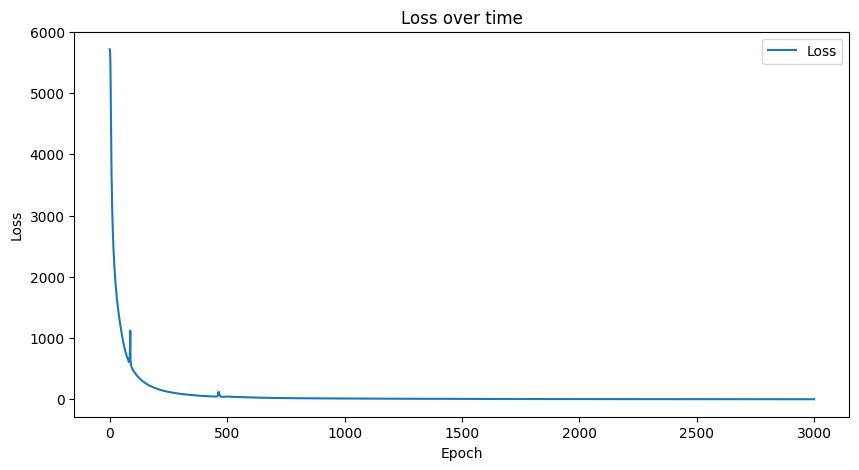

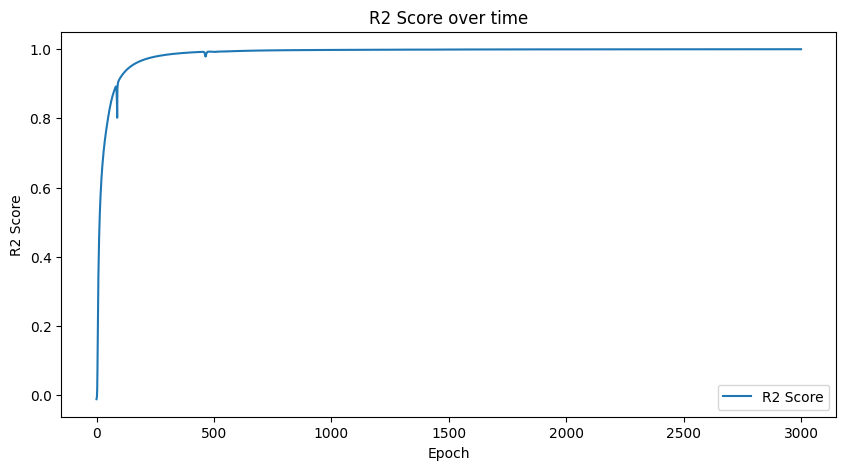

Final Test Loss (MSE): 42.02000853855637
Final Test R2 Score: 0.9923605087485139
Average Training MSE: 78.29434449214381


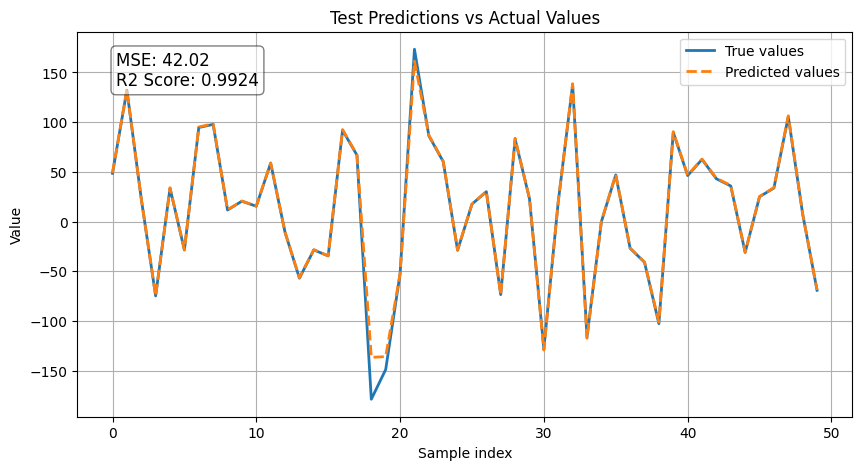

In [91]:
# Adjust these variables as necessary
hidden_dim = 8
learning_rate = .05
epochs = 3000

# Train the model and get the loss and R2 score histories
trained_params, loss_history, r2_history = train(X_train, Y_train, hidden_dim, learning_rate, epochs, sigmoid, sigmoid_derivative)

# Evaluate the model on the test set to get the final MSE and R2 score
Y_hat_test, test_loss = test(X_test, Y_test, trained_params)
# test_r2_score = r2_score(Y_test.flatten(), Y_hat_test.flatten())  # If using sklearn
test_r2_score = r2_score_manual(Y_test, Y_hat_test)  # Manual calculation


# Plot the loss over time
plt.figure(figsize=(10,5))
plt.plot(loss_history, label='Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss over time')
plt.legend()
plt.show()

#Plot the R2 score over time
plt.figure(figsize=(10,5))
plt.plot(r2_history, label='R2 Score')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.title('R2 Score over time')
plt.legend()
plt.show()


# Report the final test loss and R2 score
print(f"Final Test Loss (MSE): {test_loss}")
print(f"Final Test R2 Score: {test_r2_score}")

# If needed, calculate the average training MSE
average_training_mse = np.mean(loss_history)
print(f"Average Training MSE: {average_training_mse}")

plt.figure(figsize=(10,5))

# Plot true vs predicted values
plt.plot(Y_test.flatten(), label='True values', linewidth=2)
plt.plot(Y_hat_test.flatten(), label='Predicted values', linestyle='--', linewidth=2)

# Add statistical information as text
plt.text(0.05, 0.95, f'MSE: {test_loss:.2f}\nR2 Score: {test_r2_score:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Enhance readability
plt.title('Test Predictions vs Actual Values')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.show()




1. I used a linear activation function for the output layer because its better than non-linear functions like sigmoid because linear functions allow the network to output a range of values

2. There should be one neuron in the output layer, since we are doing a regression model and only want to predict a single value.

3. Already reported in the graph output above. Final test MSE = 42.02, Final test R score = .99

4. Already reported in the graph output above


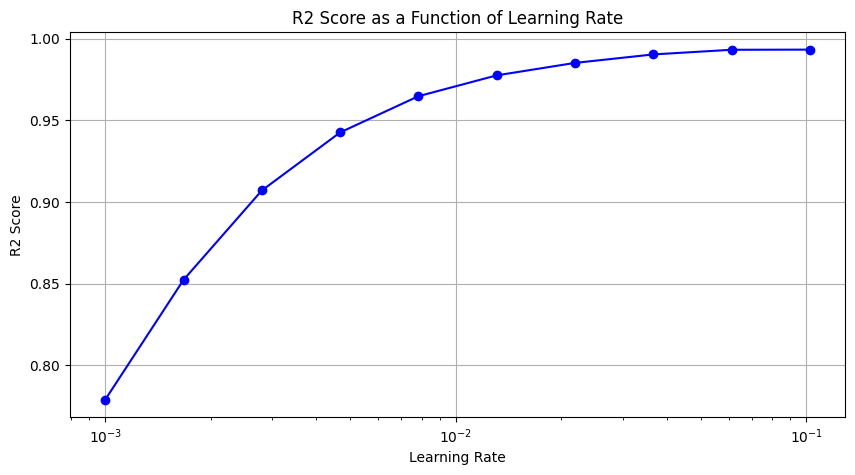

In [92]:
# Define the range of learning rates to test
learning_rates = np.logspace(-3, -.99, 10)  # Generates 10 values between 0.001 and 1.0 on a log scale


plt.figure(figsize=(10, 5))
plt.semilogx(learning_rates, evaluate_learning_rates(X_train, Y_train, X_test, Y_test, learning_rates, hidden_dim, epochs), marker='o', linestyle='-', color='b')
plt.xlabel('Learning Rate')
plt.ylabel('R2 Score')
plt.title('R2 Score as a Function of Learning Rate')
plt.grid(True)
plt.show()



5. As shown in the graph above, as the learning rate gets closer to 1, the R2 score increases and gets closer to 1.

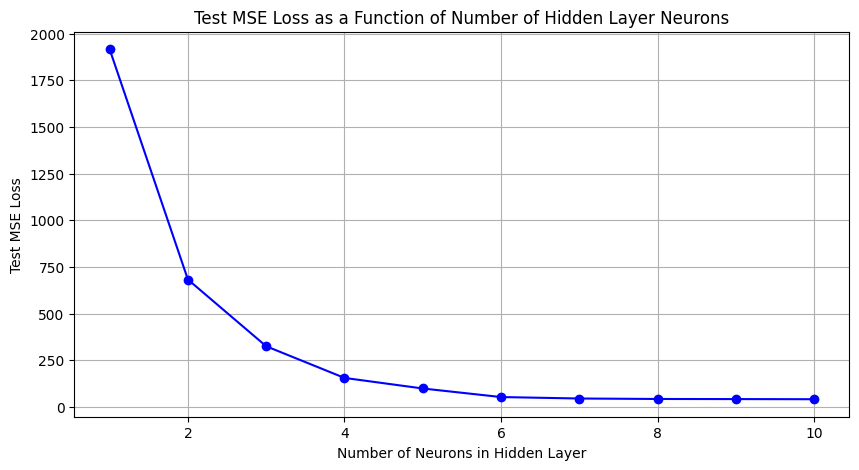

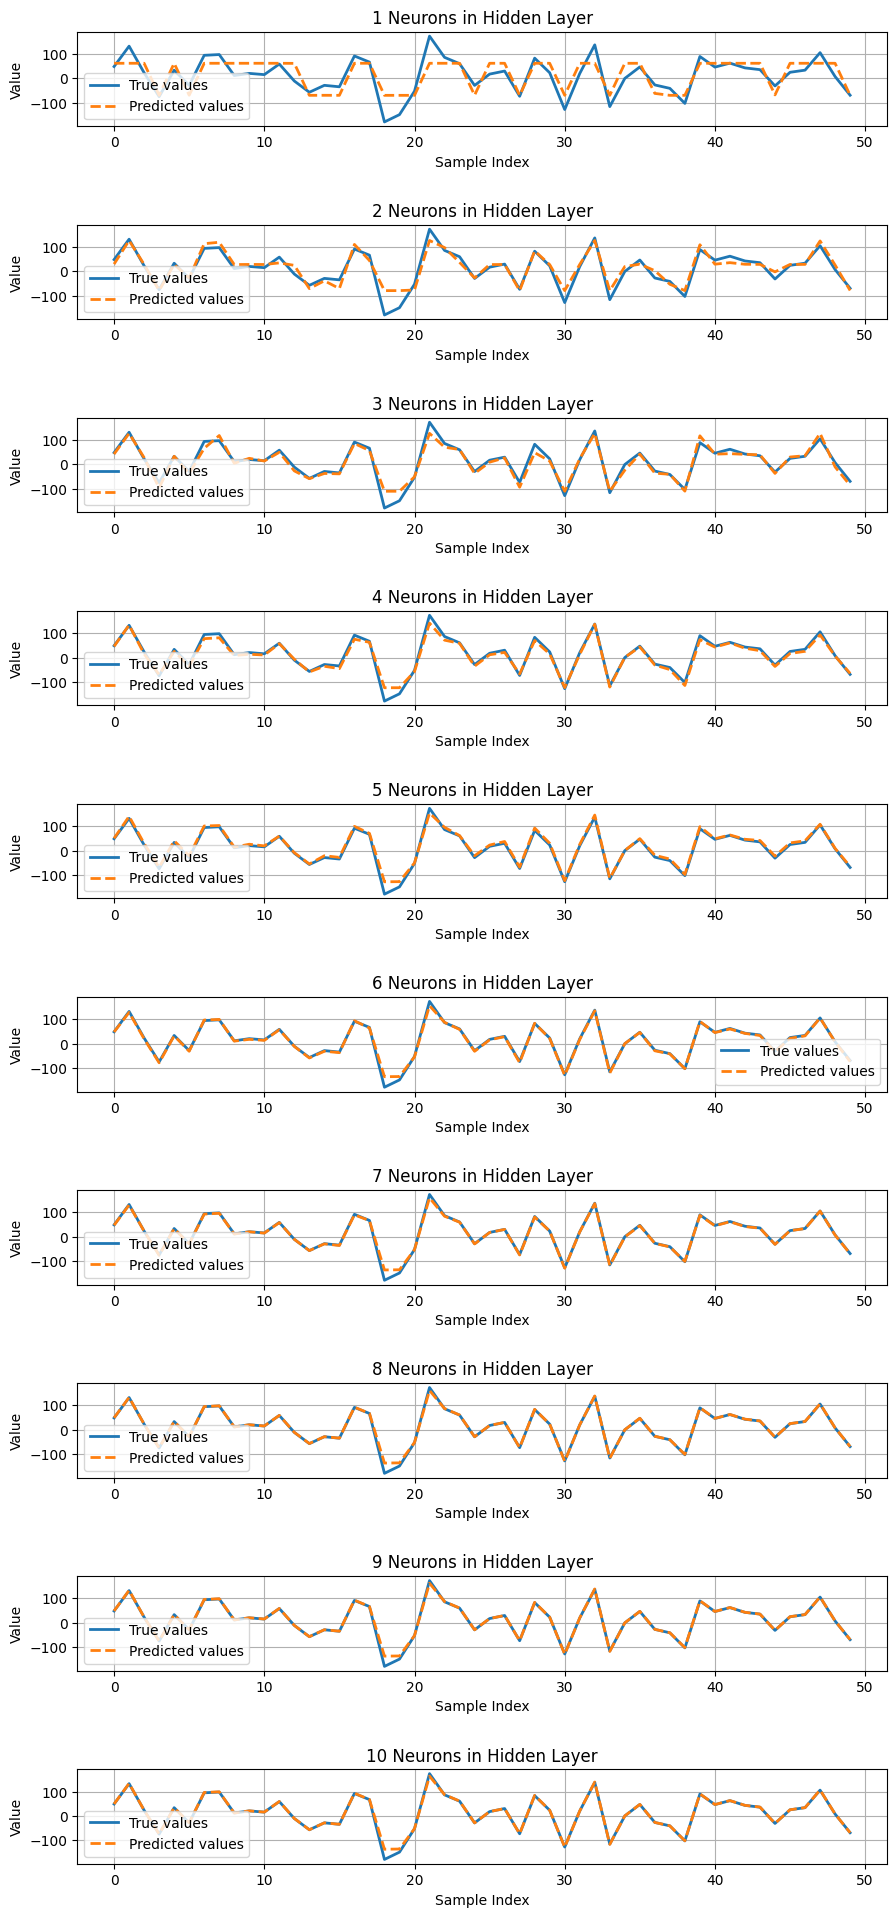

In [93]:
neuron_range = range(1, 11)
evaluate_hidden_layer_neurons(X_train, Y_train, X_test, Y_test, neuron_range, learning_rate, epochs)
activation_functions = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'tanh': (tanh, tanh_derivative),
    'relu': (relu, relu_derivative)
}


6.
  a. The update rule would not need to be changed, because the update rule is based on partial derivatives of the loss function. And these derivatives as well as the update rule, remain the same no matter what the dimensions are of the parameters.
  b. As shown in the graphs above, with a very small amount of neurons, like 1 or 2, it underfits because it cannot capture the complexity of the data. As the number of neurons increases, the loss decreases until it reaches 6 neurons, and from there on out the loss stays the same.


Training with sigmoid activation function.
Sigmoid Activation - Test Loss: 88.52034846513325, Final R2 Score: 0.983906466200325


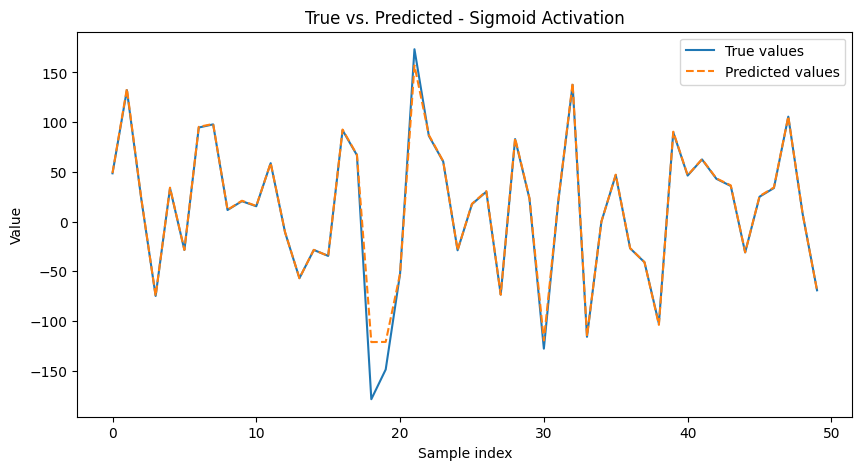


Training with tanh activation function.
Tanh Activation - Test Loss: 1722.581459192982, Final R2 Score: 0.6868242904947978


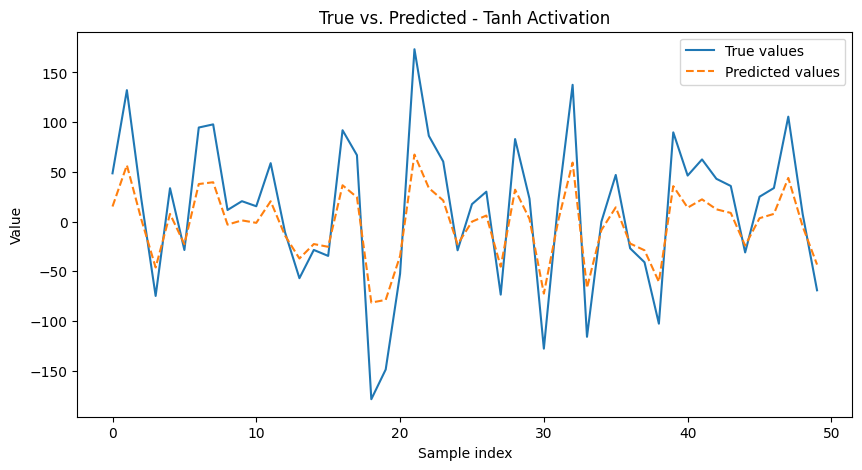


Training with relu activation function.
Relu Activation - Test Loss: 5557.374657149555, Final R2 Score: -0.010364265765651526


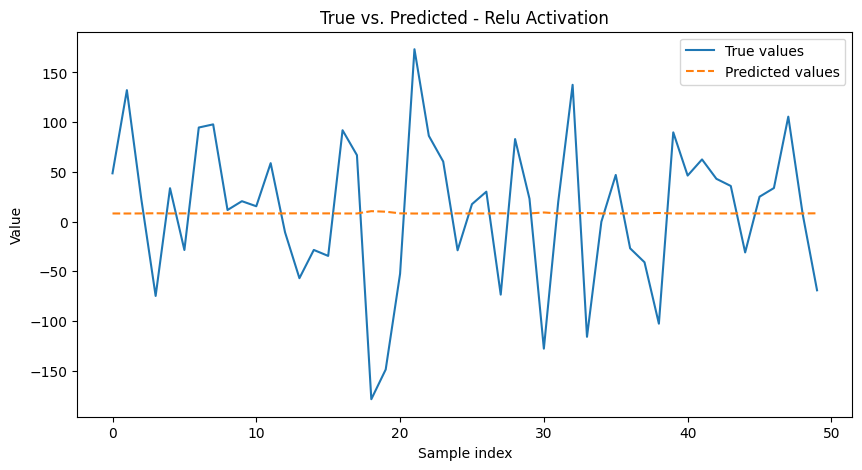

In [94]:
for name, (fn, derivative_fn) in activation_functions.items():
    print(f"\nTraining with {name} activation function.")
    num_learn = .04
    num_eps = 1500
    trained_params, loss_history, r2_history = train(X_train, Y_train, 8, num_learn, num_eps, fn, derivative_fn)
    Y_hat_test, test_loss = test(X_test, Y_test, trained_params)
    print(f"{name.capitalize()} Activation - Test Loss: {test_loss}, Final R2 Score: {r2_score_manual(Y_test, Y_hat_test)}")

    # Plot true vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(Y_test.flatten(), label='True values')
    plt.plot(Y_hat_test.flatten(), linestyle='--', label='Predicted values')
    plt.title(f'True vs. Predicted - {name.capitalize()} Activation')
    plt.xlabel('Sample index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

7.
  a. I need to change the derivative used in many of my functions, since they are only using sigmoid at the moment
  b. I will do this by generalizing all my functions that use sigmoid to where any activation function can be passed through
  c. In my outputs, I found that sigmoid performed the best, most likely because I have built my entire program to work best with sigmoid. Tanh worked somewhat Ok, but did not get the accuracy of sigmoid. As it seems to be limited on reaching the highest and lowest values. And relu did not get close to working as it stayed around 0 the entire time. I did have to change the learning rate and epochs for all the functions to work

